In [1]:
import os
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from preprocessing_sequencing import preprocess_sequences as ps
%matplotlib inline
import yaml

In [2]:
# put in path to processed data folder containing parameters yaml file 
parameters_path = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/TUR5514A4')

Load parameters

In [3]:
parameters = ps.load_parameters(directory=parameters_path)

Load all reads and combine template switching tables

In [4]:
#load template switching chunks all together
dir_path = pathlib.Path(parameters_path)
switching_tab = ps.combine_switch_tables(
        template_sw_directory=dir_path / "template_switching/analysed_chunks"
    )

Starting combining samples into one big file


In [5]:
#load file with combined reads corrected
all_seq = pd.read_csv(dir_path / "template_switching/template_switching_all_seq.csv")

Compare UMI cut-off thresholds

In [6]:
all_seq_counts =all_seq['corrected_UMI'].value_counts()

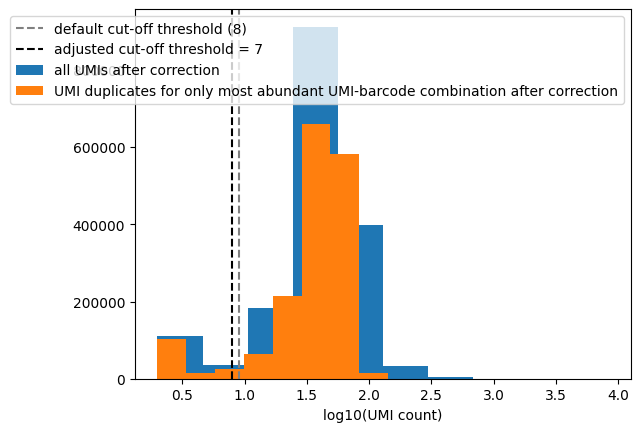

In [7]:
UMI_cutoff = parameters['UMI_cutoff']
UMI_cutoff_adjusted = 7
plt.hist(np.log10(all_seq_counts.astype(float)+1), label='all UMIs after correction')
plt.hist(np.log10((switching_tab['1st_abundant']).astype(float)+1), label='UMI duplicates for only most abundant UMI-barcode combination after correction') #these  are less likely to be UMI count errors from template switching
plt.axvline(np.log10(UMI_cutoff+1), label=f'default cut-off threshold ({UMI_cutoff})', color='grey', linestyle='dashed')
plt.axvline(np.log10(UMI_cutoff_adjusted+1), label=f'adjusted cut-off threshold = {UMI_cutoff_adjusted}', color='black', linestyle='dashed')
plt.xlabel('log10(UMI count)')
plt.legend()

Run below if you want to adjust the threshold in parameters yml

In [56]:
UMI_cutoff_adjusted = 8
with open(parameters_path/'parameters.yml', 'r') as file:
    data = yaml.load(file, Loader=yaml.FullLoader)
# Update the value in the dictionary
data['UMI_collapse_parameters']['UMI_cutoff'] = UMI_cutoff_adjusted
with open(parameters_path/'parameters.yml', 'w') as file:
    yaml.dump(data, file)

Now let's look at the distribution of putative template switching events versus expected number of UMI duplicates occuring by chance

In [15]:
# what frequency of duplicates would you expect in the library?
UMI_diversity = pow(4,14)
number_UMIs = len(switching_tab)
liklihood_two_molecules_the_same = (1/UMI_diversity)*number_UMIs
print(f"Number of duplicate UMIs expected by chance is {liklihood_two_molecules_the_same*100} %")

Number of duplicate UMIs expected by chance is 0.6246242672204971 %


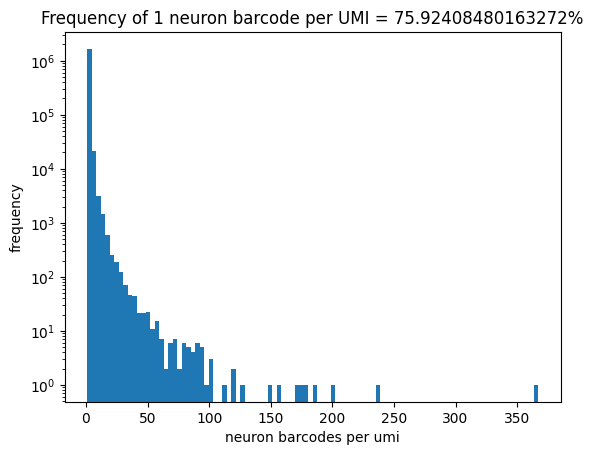

In [17]:
#plot frequency distribution of umi's associated with different neuron barcodes (i.e. template switching if # neuron barcodes associated with same umi >1)
plt.title(f"Frequency of 1 neuron barcode per UMI = {(len(switching_tab[switching_tab['different_neurons']==1]))/(len(switching_tab))*100}%", fontsize=12)
plt.yscale('log')
plt.xlabel('neuron barcodes per umi')
plt.ylabel('frequency')#plt.hist(np.log10(switching_tab['different_neurons'].astype(float)+1))
plt.hist(switching_tab['different_neurons'], bins = 100)
plt.yscale('log')

In order to distinguish between real template switching events (versus putative junk or re-used UMI's) let's look at the relative abundance of UMI counts of the same UMI associated with different neuron barcodes. Cut-off is determined by the different population distributions based on relative abundance of UMI counts. Template switching takes place during a PCR cycle. Therefore, one would expect the real UMI-barcode combination to be present at higher UMI counts than template switching events. UMI-barcode combinations found in similar abundance may not be template switching events. Therefore a minimum cut-off threshold is determined manually by inspecting distribution of populations associated with 1st/2nd most abundant UMIs.

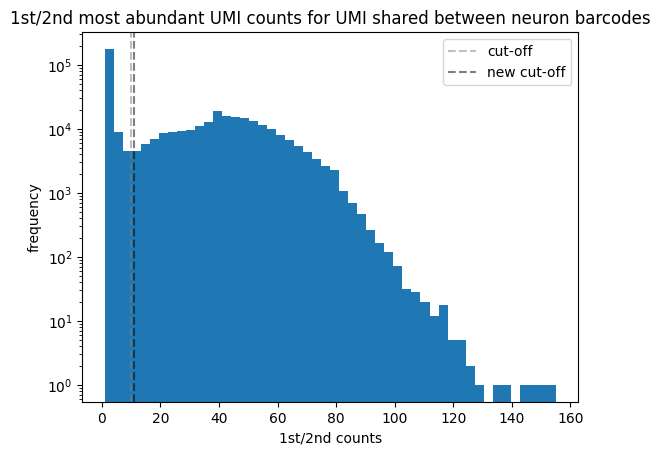

In [23]:
#within the umi's sharing a barcode, what is the distribution of 1st/second most abundant?
template_abundance_cutoff = parameters['template_switch_abundance']
altered_template_abundance_cutoff = 11
template_switches = switching_tab[switching_tab['different_neurons']>1]
plt.hist((template_switches['1st_abundant']/template_switches['2nd_abundant']), bins=50)
plt.title('1st/2nd most abundant UMI counts for UMI shared between neuron barcodes', fontsize=12)
plt.xlabel('1st/2nd counts')
plt.ylabel('frequency')
plt.yscale('log')
plt.axvline(x =template_abundance_cutoff, linestyle='dashed', color = "Grey", label = "cut-off", alpha=0.5)
plt.axvline(x =altered_template_abundance_cutoff, linestyle='dashed', color = "Black", label = "new cut-off", alpha=0.5)
plt.legend()


In [19]:
parameters

{'UMI_cutoff': 8,
 'barcode_range': [1, 91],
 'num_umi': 30000,
 'pause_before_matching': True,
 'template_switch_abundance': 10,
 'BARCODE_DIR': '/nemo/lab/znamenskiyp/data/instruments/raw_data/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/sample_barcodes.txt',
 'MOUSE': 'FIAA32.6a',
 'NOTES': 'Source sites re-sequenced as UMI count low, therefore processing performed on both TUR5514A4 (all but source diluted 1/4) and TUR5514A4 (source only). Template corrected TUR5514A4 then replaced the same source barcode files that were undersequenced for the full run in a common folder for barcode matching step.',
 'PROCESSED_DIR': '/nemo/lab/znamenskiyp/home/shared/projects',
 'PROJECT': 'turnerb_A1_MAPseq',
 'RAW_DIR': '/nemo/lab/znamenskiyp/data/instruments/raw_data/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing',
 'SCRIPT_PATH': '/camp/home/turnerb/home/users/turnerb/code/MAPseq_processing',
 'SLURM_DIR': '/camp/home/turnerb/slurm_logs',
 'max_reads_per_correction': 10000000,
 'neuron_bc_l

In [50]:
data

{'general_expt_parameters': {'NOTES': 'Source sites re-sequenced as UMI count low, therefore processing performed on both TUR5514A4 (all but source diluted 1/4) and TUR5514A4 (source only). Template corrected TUR5514A4 then replaced the same source barcode files that were undersequenced for the full run in a common folder for barcode matching step.',
  'PROJECT': 'turnerb_A1_MAPseq',
  'MOUSE': 'FIAA32.6a',
  'BARCODE_DIR': '/nemo/lab/znamenskiyp/data/instruments/raw_data/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/sample_barcodes.txt',
  'RAW_DIR': '/nemo/lab/znamenskiyp/data/instruments/raw_data/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing',
  'PROCESSED_DIR': '/nemo/lab/znamenskiyp/home/shared/projects',
  'SLURM_DIR': '/camp/home/turnerb/slurm_logs',
  'SCRIPT_PATH': '/camp/home/turnerb/home/users/turnerb/code/MAPseq_processing'},
 'split_samples_parameters': {'acq_id': 'TUR5514A4',
  'overwrite': True,
  'n_mismatch': 2,
  'r1_part': [0, 32],
  'r2_part': [0, 30],
  'consen

(array([1.18956e+05, 2.31520e+04, 3.08760e+04, 4.51430e+04, 5.85270e+04,
        6.66460e+04, 7.35380e+04, 8.33420e+04, 9.84250e+04, 1.11954e+05,
        1.15562e+05, 1.07588e+05, 9.08740e+04, 7.17420e+04, 5.42730e+04,
        4.02020e+04, 2.93190e+04, 2.01990e+04, 1.35960e+04, 8.62000e+03,
        4.90600e+03, 2.76300e+03, 1.33700e+03, 7.27000e+02, 3.48000e+02,
        1.69000e+02, 1.02000e+02, 5.00000e+01, 3.70000e+01, 2.40000e+01,
        1.10000e+01, 6.00000e+00, 6.00000e+00, 3.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.0, 5.02, 9.04, 13.059999999999999, 17.08, 21.099999999999998,
        25.119999999999997, 29.139999999999997, 33.16, 37.17999999999999,
        41.199999999999996, 45.22, 49.239999999999995, 53.25999999999999,
        57.279999999999994, 61.3, 65.32, 69.3399

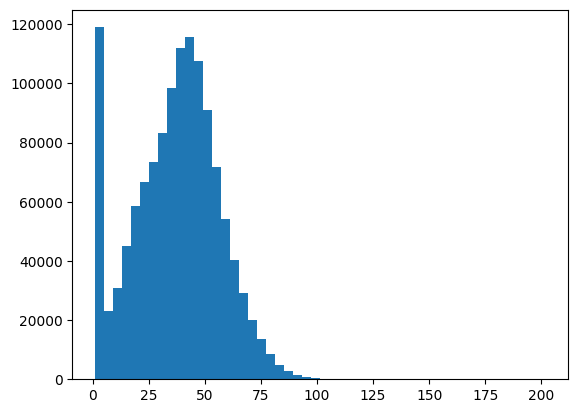

In [15]:
only_ones = switching_tab[switching_tab['different_neurons']==1]
plt.hist(only_ones["1st_abundant"], bins=50)

In [13]:
switching_tab

,total,different_neurons,1st_abundant,2nd_abundant,sequence_of_1st,sample_of_1st,chunk,UMI
0,99,3,97,1,TGCACAATTCAGGTCAATAACTTCGGGATGCTTTATATTGTTACTA,BC64,63,TTATATTGTTACTA
1,67,1,67,0,GTTATATGATCTGGTTTTGGTATGGAAATTTCTTCTAAACGCTAAA,BC64,63,TTCTAAACGCTAAA
2,97,2,96,1,TACAGTGTGCACGTGCTCCCCTTGATTCTGCTGATTTCCATTTGCC,BC64,63,GATTTCCATTTGCC
3,60,1,60,0,TGCACAATTCAGGTCAATAACTTCGGGATGCTTTTCACAAACCATA,BC64,63,TTTCACAAACCATA
4,88,1,88,0,TGATTACATCGCCTTGATATATCTTGTCGTTTCCCTCCATTTCCTA,BC64,63,CCCTCCATTTCCTA
...,...,...,...,...,...,...,...,...
29995,20,1,20,0,TCAATGTTGGCCAGATACATTCATCAGCATTCGCATTTTTCGTGAT,BC36,218,GCATTTTTCGTGAT
29996,29,2,28,1,ACCTGCAGGACCTGCGTACATCCATCCACTTTTGATGTTTCAGAGA,BC36,218,TGATGTTTCAGAGA
29997,5,1,5,0,CTGGCCGCTTGTGTGCATCTTCATGTATGTTTATGGGCAAGCCGTA,BC36,218,ATGGGCAAGCCGTA
29998,29,1,29,0,CGGCTTCTTCTCAAGGGATATTTTGGAATTTCTGGTGTTAGAAATT,BC36,218,TGGTGTTAGAAATT


In [ ]:
#to see how things look after removing template switching 'junk'
directory = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/Sequencing/Processed_data/UpdatedApril/preprocessed_seq_corrected/template_switching/analysed_chunks')
template_switching_check = pd.DataFrame(
        columns=[
            "UMI",
            "total",
            "different_neurons",
            "1st_abundant",
            "2nd_abundant",
            "sequence_of_1st",
            "sample_of_1st",
            "chunk",
        ]
    ).set_index("UMI")
print("starting combining samples into one big file", flush=True)
for file in os.listdir(directory):
    barcode_file = directory / file
    if barcode_file.stem.startswith("template_switching_chunk_"):
        bc_table = pd.read_csv(barcode_file)
        sample = barcode_file.stem.split("template_switching_chunk_", 1)[1]
        bc_table["chunk"] = sample
        template_switching_check = pd.concat([template_switching_check, bc_table])
#bla = pd.read_csv(directory / "template_switching/template_switching_all_seq.csv")

In [ ]:
#ignore duplicates
only_ones = template_switching_check[template_switching_check['different_neurons']==1]
plt.hist(only_ones["1st_abundant"], bins=50)
# plt.xticks(range(4),np.logspace(0,3,4))
plt.title('Number of reads per UMI post correction', fontsize=12)
plt.yscale('log')

plt.axvline(x = 4, color = "Black", label = "cut-off")
plt.legend(loc = 'upper right')
plt.xlabel('UMI counts')
plt.ylabel('Frequency')

In [ ]:
switches = template_switching_check[template_switching_check['different_neurons']>1]
plt.hist(switches[switches['1st_abundant']/switches['2nd_abundant']<10]['chunk'], bins=91)

In [ ]:
directory = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/Sequencing/Processed_data/UpdatedApril/preprocessed_seq_corrected')


In [ ]:
bla = pd.read_csv(directory / "template_switching/template_switching_all_seq.csv")

In [54]:
parameters['r1_part']

[0, 32]

In [ ]:
barcode_file_range =96
dir_path = pathlib.Path(directory)
value_counts = pd.DataFrame()
out_dir = dir_path.joinpath("Final_processed_sequences")
pathlib.Path(out_dir).mkdir(parents=True, exist_ok=True)
for i in range(barcode_file_range):
    barcode = f"BC{i+1}"
    sample_file = dir_path / f"corrected_{barcode}.csv"
    if os.path.isfile(sample_file):
        sample_table = pd.read_csv(sample_file)
        sample_table["combined"] = (sample_table["corrected_sequences_neuron"]+ sample_table["corrected_sequences_umi"])
        total_counts =sample_table['combined'].value_counts().rename_axis('sequence').reset_index(name='counts')
        value_counts = pd.concat([value_counts, total_counts])

In [ ]:
plt.hist(value_counts["counts"], bins=100)
# plt.xticks(range(4),np.logspace(0,3,4))
plt.title('Number of reads per UMI post correction', fontsize=12)
plt.yscale('log')

#plt.axvline(x = 9, color = "Black", label = "cut-off")
plt.legend(loc = 'upper right')
plt.xlabel('UMI counts')
plt.ylabel('Frequency')

In [ ]:
value_counts.counts.sum()

In [ ]:
barcode_range =91
raw_value_counts = pd.DataFrame()
raw_path = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/Sequencing/Processed_data/New/')
for x in range(barcode_range):
        barcode_num = "BC" + str(x + 1) + ".txt"
        if barcode_num != 'BC36.txt' and barcode_num != 'BC65.txt':
            barcode_file = raw_path.joinpath(barcode_num)
            raw_bc = pd.read_csv(u
                barcode_file, delimiter="\t", skiprows=lambda x: (x != 0) and not x % 2
            )   
            raw_total_counts = raw_bc.value_counts().rename_axis('sequence').reset_index(name='counts')
            raw_value_counts = pd.concat([raw_value_counts, raw_total_counts])

In [ ]:
plt.hist(raw_value_counts["counts"], bins=100)
plt.title('Number of reads per UMI (pre error correction)', fontsize=12)
plt.yscale('log')

#plt.axvline(x = 9, color = "Black", label = "cut-off")
plt.legend(loc = 'upper right')
plt.xlabel('UMI counts')
plt.ylabel('Frequency')

In [ ]:
raw_value_counts['counts'].sum()

In [ ]:
plt.hist(value_counts["counts"], bins=200)
plt.title('Number of reads per UMI (pre error correction)', fontsize=12)
plt.yscale('log')

#plt.axvline(x = 9, color = "Black", label = "cut-off")
plt.legend(loc = 'upper right')
plt.xlabel('UMI counts')
plt.ylabel('Frequency')

In [ ]:
plt.hist(value_counts["counts"], bins=200)
# plt.xticks(range(4),np.logspace(0,3,4))
plt.title('Number of reads per UMI', fontsize=12)
plt.yscale('log')
plt.xlim(0,400)
plt.axvline(x = 9, color = "Black", label = "cut-off")
plt.legend(loc = 'upper right')
plt.xlabel('UMI counts')
plt.ylabel('Frequency')

In [ ]:
sorting_directory = '/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/Sequencing/Processed_data/BC_split/temp/increased_cutoff'

sorting_dir = pathlib.Path(sorting_directory)
all_seq = pd.DataFrame()
for barcode_file in os.listdir(sorting_dir):
    if barcode_file.startswith("neuroncounts_"):
        to_read = pd.read_csv(sorting_dir/barcode_file)
        sequences = to_read["sequence"]
        all_seq =pd.concat([all_seq, sequences])
all_seq_unique =all_seq.value_counts().rename_axis('sequence').reset_index(name='counts')


In [ ]:
samples = list(range(1, 92))
zeros = np.zeros(shape=(len(all_seq_unique['sequence']),len(samples)))
barcodes_across_sample = pd.DataFrame(zeros, columns=samples)
barcodes_across_sample =barcodes_across_sample.set_index(all_seq_unique['sequence'])

In [ ]:
for file in os.listdir(sorting_directory):
    barcodefile= sorting_dir/file
    if barcodefile.stem.startswith("neuroncounts_"):
        toread = pd.read_csv(barcodefile)
        sample = int(barcodefile.stem.split("neuroncounts_BC", 1)[1])
        for r, sequence in toread["sequence"].items():
            barcodes_across_sample.loc[sequence,sample] = toread["counts"][r]
        

In [ ]:
summary = barcodes_across_sample.sum(axis=1)
plt.hist(summary, bins=3)


In [ ]:
min(summary)

In [ ]:
bla = barcodes_across_sample[29][barcodes_across_sample[29]>0]
bla

In [ ]:
barcodes_across_sample.loc['TTGTTTAGATAGTTTGTACCTGTGCGTCGGTT',1]

In [ ]:
for barcode in all_seq_unique:
index += 1
#for barcodefile in os.listdir(sorting_directory):

if barcodefile.startswith("neuroncounts_"):
    toread = pd.read_csv(barcodefile)
    sample = int(barcodefile.split("neuroncounts_BC", 1)[1][: -len(".csv")])
    for r, sequence in toread["sequence"].items():
        barcodes_across_sample.loc[sequence,sample] = toread["counts"][r]
        

In [ ]:
samples = list(range(1, 92))
zeros = np.zeros(shape=(len(all_seq_unique['sequence']),len(samples)))
barcodes_across_sample = pd.DataFrame(zeros, columns=samples)

In [ ]:
barcodes_across_sample.set_index(all_seq_unique['sequence'])

In [ ]:
barcodefile.stem.split("neuroncounts_BC", 1)[1]

In [ ]:
barcodefile = sorting_dir/'neuroncounts_BC29.csv'
for i, row in all_seq_unique.iterrows():
    barcode = row['sequence']
    toread = pd.read_csv(barcodefile)
    sample = int(barcodefile.stem.split("neuroncounts_BC", 1)[1])
    for r, sequence in toread["sequence"].items():
        if sequence == barcode:
            barcodes_across_sample.at[index, sample] = toread["counts"][r]

In [ ]:
df.set_index('month')
for r, sequence in toread["sequence"].items():

In [ ]:
for i, barcode in all_seq_unique.iterrows():
    print

In [ ]:
# Note this figure was used in Shirom Chabra's code to evaluate the UMI cut-off.
plt.hist(np.log(total_counts["counts"])/np.log(10), bins=50)
# plt.xticks(range(4),np.logspace(0,3,4))
plt.title('Number of UMIs per barcode', fontsize=12)
plt.yscale('log')
plt.axvline(x = np.log(2), color = "Black", label = "cut-off")
plt.legend(loc = 'upper left')

In [ ]:
barcode_file

In [ ]:
plt.hist(total_counts["counts"], bins=100)
# plt.xticks(range(4),np.logspace(0,3,4))
plt.title('Number of UMIs per barcode', fontsize=12)
plt.yscale('log')
plt.axvline(x = 9, color = "Black", label = "cut-off")
plt.legend(loc = 'upper right')

In [ ]:
plt.hist(value_counts["counts"], bins=100)
# plt.xticks(range(4),np.logspace(0,3,4))
plt.title('Number of UMIs per barcode', fontsize=12)
plt.yscale('log')

plt.axvline(x = 9, color = "Black", label = "cut-off")
plt.legend(loc = 'upper right')
plt.xlabel('UMI counts')
plt.ylabel('Frequency')

In [ ]:
# set new file with cut-off as 7
def combineUMIandBC(directory, outdirectory, barcodefilerange=96):
    """
    Function to combine corrected barcodes and UMI's for each read and collect value counts.
    Also to detect degree of template switching between reads by seeing if UMI is shared by more than one barcode
    Also to split spike RNA from neuron barcodes, by whether contains N[24]ATCAGTCA (vs N[32]CTCT for neuron barcodes)
    Args:
        directory: temp file where the intermediate UMI and barcode clustered csv files are kept
        barcodefilerange: the number of samples you want to loop through (default set for 96)
    """
    os.chdir(directory)
    UMI_cutoff = 7
    for i in range(barcodefilerange):
        os.chdir(directory)
        num = i + 1
        barcode = "BC%s" % num
        neuronfile = "neuronBCcorrected_%s.csv" % barcode
        umifile = "UMIs_corrected_%s.csv" % barcode
        if os.path.isfile(neuronfile) and os.path.isfile(umifile):
            print("processing %s" % barcode, flush=True)
            combined = pd.concat(
                [pd.read_csv(neuronfile), pd.read_csv(umifile)], axis=1
            )
            combined["combined"] = (
                combined["corrected_neuronBC"] + combined["corrected_umi"]
            )
            spikein = combined[
                combined["combined"].str.contains("^.{24}ATCAGTCA") == True
            ].rename_axis("sequence")
            neurons = combined[
                combined["combined"].str.contains("^.{30}[CT][CT]") == True
            ].rename_axis("sequence")
            neuroncounts = (
                neurons["combined"]
                .value_counts()
                .rename_axis("sequence")
                .reset_index(name="counts")
            )
            counts_spike = (
                spikein["combined"]
                .value_counts()
                .rename_axis("sequence")
                .reset_index(name="counts")
            )
            # only take umi counts greater or equal to 2
            neuroncounts = neuroncounts[neuroncounts["counts"] >= UMI_cutoff]
            counts_spike = counts_spike[counts_spike["counts"] >= UMI_cutoff]
            counts_spike["barcode"] = counts_spike["sequence"].str[:32]
            neuroncounts["barcode"] = neuroncounts["sequence"].str[:32]
            spikeneuron = (
                counts_spike["barcode"]
                .value_counts()
                .rename_axis("sequence")
                .reset_index(name="counts")
            )
            neuroncounts = (
                neuroncounts["barcode"]
                .value_counts()
                .rename_axis("sequence")
                .reset_index(name="counts")
            )
            os.chdir(outdirectory)
            print("finished %s" % barcode, flush=True)
            tosaveBC = "neuroncounts_%s.csv" % barcode
            tosavespike = "spikecounts_%s.csv" % barcode
            spikeneuron.to_csv(tosavespike)
            neuroncounts.to_csv(tosaveBC)
        else:
            print("both not there for %s" % barcode)

In [ ]:
out_dir = dir_path.joinpath('increased_cutoff')
combineUMIandBC(directory=directory, outdirectory=out_dir, barcodefilerange=96)

In [ ]:
import os
import numpy as np
import pandas as pd
from umi_tools import UMIClusterer
from datetime import datetime
import subprocess, shlex
import pathlib